In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import operator
from collections import Counter
import itertools as it

# visualize the important characteristics of the dataset
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pylab
%matplotlib inline

# Some options
pd.set_option("display.max_columns", 100)
pylab.rcParams['figure.figsize'] = (10, 6)
markers=('|', '_','v', 's', 'd', '*', '^')
color_map = {0:'blue', 1:'red', 2:'white', 3: 'cyan', 4:'green', 5:'yellow', 6:'magenta'}

# define some functions

def mapToTSNE(x_in):
    # scale extended features
    standard_scaler = StandardScaler()
    x_std = standard_scaler.fit_transform(x_in)

    # t-distributed Stochastic Neighbor Embedding (t-SNE) visualization
    tsne = TSNE(n_components=2, random_state=0)
    
    return tsne.fit_transform(x_std)

def plotTSNE(label, x_in, y_in):
    
    y = y_in[label]
    y_frequencies = Counter(y.values)
    y_ratios = Counter({key: value / y.size for key, value in y_frequencies.items()})
    print(y_frequencies)
    print(y_ratios)

    # encode the class label
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # do some python magic so the least frequent labels will be drawn in end
    classesSortedByFrequency = [sortedLabel[0:2] for sortedLabel in sorted([label + (y_ratios[label[1]],) 
                      for label in list(enumerate(label_encoder.classes_))], 
                 key=operator.itemgetter(2), reverse=True)]

    # scatter plot the sample points among the classes
    plt.figure()
    for idx, cl in classesSortedByFrequency:
        plt.scatter(x=x_in[y==idx,0], y=x_in[y==idx,1], c=color_map[idx], marker=markers[idx], label=cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left', title=label)
    plt.title('t-SNE visualization for GoT characters')
    plt.show()

## Step 1: Load the data

In [26]:
battles_df = pd.read_csv("battles.csv")
characterDeaths_df = pd.read_csv("character-deaths.csv")
characterPredictions_df = pd.read_csv("character-predictions.csv")

In [3]:
battles_df.head()

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,defender_2,defender_3,defender_4,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,attacker_commander,defender_commander,summer,location,region,note
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,NaN,NaN,NaN,win,pitched battle,1.0,0.0,15000.0,4000.0,Jaime Lannister,"Clement Piper, Vance",1.0,Golden Tooth,The Westerlands,NaN
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Baratheon,NaN,NaN,NaN,win,ambush,1.0,0.0,NaN,120.0,Gregor Clegane,Beric Dondarrion,1.0,Mummer's Ford,The Riverlands,NaN
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,NaN,NaN,NaN,win,pitched battle,0.0,1.0,15000.0,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",1.0,Riverrun,The Riverlands,NaN
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey/Tommen Baratheon,Stark,NaN,NaN,NaN,Lannister,NaN,NaN,NaN,loss,pitched battle,1.0,1.0,18000.0,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",1.0,Green Fork,The Riverlands,NaN
4,Battle of the Whispering Wood,298,5,Robb Stark,Joffrey/Tommen Baratheon,Stark,Tully,NaN,NaN,Lannister,NaN,NaN,NaN,win,ambush,1.0,1.0,1875.0,6000.0,"Robb Stark, Brynden Tully",Jaime Lannister,1.0,Whispering Wood,The Riverlands,NaN


In [4]:
characterDeaths_df.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,NaN,NaN,NaN,NaN,1,1,0,0,1,0,0


In [5]:
characterPredictions_df.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,105.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


## Show intersection between <br> characterDeaths_df and characterPredictions_df

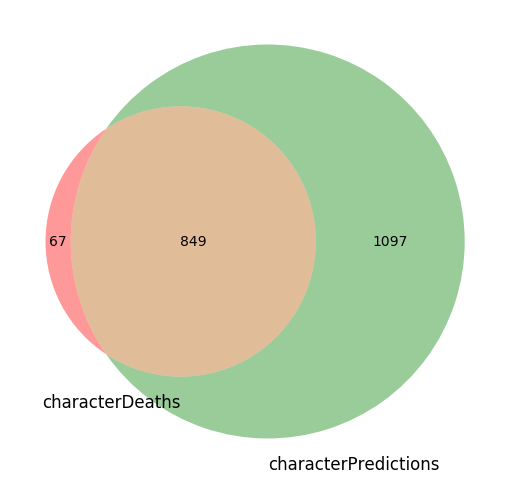

In [6]:
intersection = list(set(characterPredictions_df['name']) & set(characterDeaths_df['Name']))
characterPredictions_noIntersect_df = characterPredictions_df[~characterPredictions_df['name'].isin(intersection)]
characterDeaths_noIntersect_df = characterDeaths_df[~characterDeaths_df['Name'].isin(intersection)]

venn2([set(characterDeaths_df['Name']), set(characterPredictions_df['name'])], set_labels=('characterDeaths', 'characterPredictions'))
plt.show()

### I did not consider the characterDeaths data for this analysis because there is not much value of it.<br> First, I will only work with characterPredictions_df and then extract more features.

## Step 2: Generate features x and labels y

In [7]:
bookCount = characterPredictions_df[['book1','book2','book3','book4','book5']].sum(1)
x = characterPredictions_df[['alive','name', 'numDeadRelations','popularity']].copy()
x['bookCount'] = bookCount
x = x.set_index('name')
x.head()

,alive,numDeadRelations,popularity,bookCount
name,,,,
Viserys II Targaryen,0.054,11,0.605351,0
Walder Frey,0.387,1,0.896321,5
Addison Hill,0.493,0,0.267559,1
Aemma Arryn,0.076,0,0.183946,0
Sylva Santagar,0.617,0,0.043478,1


In [8]:
y_all = characterPredictions_df[['name','male','book1','book2','book3','book4','book5',
                                 'isMarried','boolDeadRelations','isPopular','isAlive']]
y_all = y_all.set_index('name')
y_all.head()

,male,book1,book2,book3,book4,book5,isMarried,boolDeadRelations,isPopular,isAlive
name,,,,,,,,,,
Viserys II Targaryen,1,0,0,0,0,0,0,1,1,0
Walder Frey,1,1,1,1,1,1,1,1,1,1
Addison Hill,1,0,0,0,1,0,0,0,0,1
Aemma Arryn,0,0,0,0,0,0,1,0,0,0
Sylva Santagar,0,0,0,0,1,0,1,0,0,1


In [9]:
x_std_2d = mapToTSNE(x)

In [10]:
y_all.columns

Index(['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried',
       'boolDeadRelations', 'isPopular', 'isAlive'],
      dtype='object')

Counter({0: 1831, 1: 115})
Counter({0: 0.9409044193216856, 1: 0.05909558067831449})


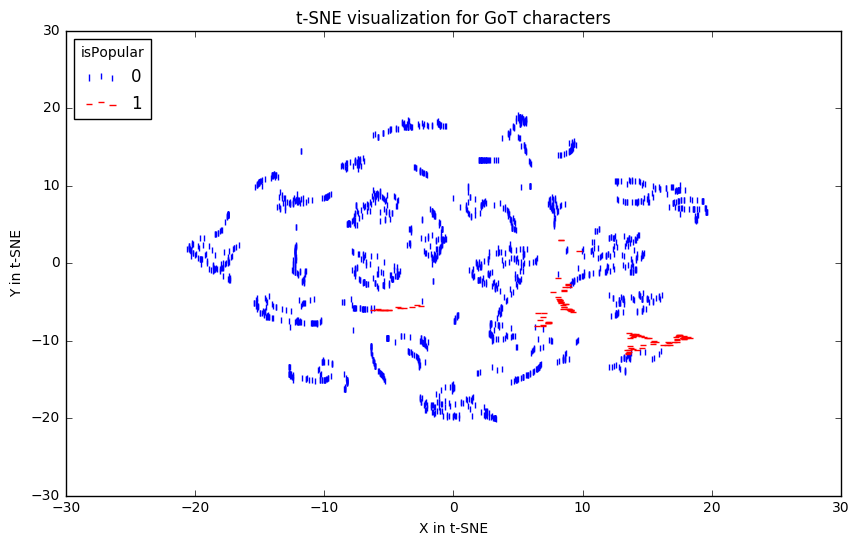

In [11]:
plotTSNE("isPopular", x_std_2d, y_all)

## Step 3: Generate more features x and labels y from battle data

### Generate features from battle data

In [12]:
# to battle - get all them features!

battles_features = battles_df[
    ['attacker_outcome', 'major_death','major_capture', 
     'attacker_size', 'defender_size', 'attacker_commander', 'defender_commander',
     'battle_type']].copy()
battles_features['attackerCount'] = battles_df[['attacker_1','attacker_2','attacker_3','attacker_4']].notnull().sum(1)
battles_features['defenderCount'] = battles_df[['defender_1','defender_2','defender_3','defender_4']].notnull().sum(1)

battles_features['attackingCommanders'] = battles_df['attacker_commander'].map(lambda x: 0 if str(x) == "nan" else len(str(x).split(",")))
battles_features['defenderCommanders'] = battles_df['defender_commander'].map(lambda x: 0 if str(x) == "nan" else len(str(x).split(",")))
battles_features['attacker_outcome'] = battles_features['attacker_outcome'].map(lambda x: 1 if x == "win" else 0)
battles_features.head()

,attacker_outcome,major_death,major_capture,attacker_size,defender_size,attacker_commander,defender_commander,battle_type,attackerCount,defenderCount,attackingCommanders,defenderCommanders
0,1,1.0,0.0,15000.0,4000.0,Jaime Lannister,"Clement Piper, Vance",pitched battle,1,1,1,2
1,1,1.0,0.0,NaN,120.0,Gregor Clegane,Beric Dondarrion,ambush,1,1,1,1
2,1,0.0,1.0,15000.0,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",pitched battle,1,1,2,2
3,0,1.0,1.0,18000.0,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",pitched battle,1,1,5,4
4,1,1.0,1.0,1875.0,6000.0,"Robb Stark, Brynden Tully",Jaime Lannister,ambush,2,1,2,1


### Generate character features based on battle features

In [13]:
# generate new features and labels for characters
x_extended = x.copy()
y_all_extended = y_all.copy()

x_extended['witnessed_wins'] = 0
x_extended['witnessed_losses'] = 0
x_extended['witnessed_own_attacker_size_mean'] = 0
x_extended['witnessed_opponent_attacker_size_mean'] = 0
x_extended['witnessed_own_defender_size_mean'] = 0
x_extended['witnessed_opponent_defender_size_mean'] = 0
x_extended['witnessed_major_deaths'] = 0
x_extended['witnessed_major_capture'] = 0
x_extended['battleCountAsAttackerCommander'] = 0
x_extended['battleCountAsDefenderCommander'] = 0
x_extended['battleCountAsCommander'] = 0

y_all_extended['hadMoreWinsThanLosses'] = 0
y_all_extended['wasAttackerCommander'] = 0
y_all_extended['wasDefenderCommander'] = 0
y_all_extended['wasCommander'] = 0
y_all_extended['preferredBattleType'] = "None"


for characterName in x_extended.index:
    
    character = x_extended.loc[characterName].copy()
    character_labels = y_all_extended.loc[characterName].copy()
    
    witnessed_own_attacker_size = 0
    witnessed_opponent_attacker_size = 0
    witnessed_own_defender_size = 0
    witnessed_opponent_defender_size = 0
    battleTypes = []
    
    for row in battles_features.iterrows():
        battle = row[1] 
        
        wasAttackerCommander = pd.notnull(battle['attacker_commander']) and characterName in battle['attacker_commander']
        wasDefenderCommander = pd.notnull(battle['defender_commander']) and characterName in battle['defender_commander']

        if (wasAttackerCommander or wasDefenderCommander):
            character['battleCountAsCommander'] += 1
            character['witnessed_wins'] += battle['attacker_outcome'] if wasAttackerCommander else (1-battle['attacker_outcome'])
            character['witnessed_losses'] += (1-battle['attacker_outcome'] if wasAttackerCommander else battle['attacker_outcome'])
    
            if (pd.notnull(battle['attacker_size'])):
                if (wasAttackerCommander):
                    witnessed_own_attacker_size += battle['attacker_size']
                else:
                    witnessed_opponent_attacker_size += battle['attacker_size']
            if (pd.notnull(battle['defender_size'])):
                if (wasDefenderCommander):
                    witnessed_own_defender_size += battle['defender_size']
                else:
                    witnessed_opponent_defender_size += battle['defender_size']
                    
            if(pd.notnull(battle['major_death'])):
                character['witnessed_major_deaths'] += battle['major_death']
            if(pd.notnull(battle['major_capture'])):
                character['witnessed_major_capture'] += battle['major_capture']
               
            character['battleCountAsAttackerCommander'] += wasAttackerCommander
            character['battleCountAsDefenderCommander'] += wasDefenderCommander
            if (pd.notnull(battle['battle_type'])):
                battleTypes.append(battle['battle_type'])
            
    # aggregate data for character
    if (character['battleCountAsAttackerCommander'] > 0):
        character_labels['wasAttackerCommander'] = 1
        character['witnessed_own_attacker_size_mean'] = witnessed_own_attacker_size / character['battleCountAsAttackerCommander']
        character['witnessed_opponent_defender_size_mean'] = witnessed_opponent_defender_size / character['battleCountAsAttackerCommander']
    
    if (character['battleCountAsDefenderCommander'] > 0):
        character_labels['wasDefenderCommander'] = 1
        character['witnessed_own_defender_size_mean'] = witnessed_own_defender_size / character['battleCountAsDefenderCommander']
        character['witnessed_opponent_attacker_size_mean'] = witnessed_opponent_attacker_size / character['battleCountAsDefenderCommander']
        
    if (character['battleCountAsCommander'] > 0):
        character_labels['hadMoreWinsThanLosses'] = int(character['witnessed_wins'] > character['witnessed_losses'])
        character_labels['wasCommander'] = 1
        battleType_frequencies = Counter(battleTypes)
        character_labels['preferredBattleType'] = max(battleType_frequencies,key=operator.itemgetter(1))
    
    x_extended.loc[characterName] = character
    y_all_extended.loc[characterName] = character_labels

In [14]:
x_extended.sort_values('battleCountAsCommander',ascending=False).head()

,alive,numDeadRelations,popularity,bookCount,witnessed_wins,witnessed_losses,witnessed_own_attacker_size_mean,witnessed_opponent_attacker_size_mean,witnessed_own_defender_size_mean,witnessed_opponent_defender_size_mean,witnessed_major_deaths,witnessed_major_capture,battleCountAsAttackerCommander,battleCountAsDefenderCommander,battleCountAsCommander
name,,,,,,,,,,,,,,,
Gregor Clegane,0.405,1.0,0.836120,5.0,6.0,1.0,4000.000000,10500.0,10000.0,3224.000000,4.0,1.0,5.0,2.0,7.0
Rob,0.705,0.0,0.003344,0.0,5.0,2.0,3829.166667,3500.0,3500.0,4787.500000,5.0,3.0,6.0,1.0,7.0
Roose Bolton,0.711,1.0,0.979933,5.0,3.0,2.0,7200.000000,2500.0,7000.0,7866.666667,3.0,2.0,3.0,2.0,5.0
Stannis Baratheon,0.036,4.0,1.000000,0.0,3.0,2.0,8875.000000,100000.0,1240.0,8862.500000,3.0,2.0,4.0,1.0,5.0
Jaime Lannister,0.352,7.0,1.000000,5.0,4.0,1.0,8625.000000,1875.0,6000.0,3500.000000,2.0,3.0,4.0,1.0,5.0


In [15]:
y_all_extended.sort_values('wasCommander',ascending=False).head()

,male,book1,book2,book3,book4,book5,isMarried,boolDeadRelations,isPopular,isAlive,hadMoreWinsThanLosses,wasAttackerCommander,wasDefenderCommander,wasCommander,preferredBattleType
name,,,,,,,,,,,,,,,
Brynden Tully,1,1,1,1,1,1,0,1,1,1,1,1,1,1,ambush
Cortnay Penrose,1,0,1,1,0,0,0,0,0,0,0,0,1,1,siege
Jaime Lannister,1,1,1,1,1,1,0,1,1,1,1,1,1,1,ambush
Robb Stark,1,0,0,0,0,0,0,1,1,0,1,1,1,1,ambush
Harrion Karstark,1,1,1,1,1,1,0,1,0,1,0,1,0,1,pitched battle


In [16]:
x_extended_std_2d = mapToTSNE(x_extended)

In [17]:
y_all_extended.columns

Index(['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried',
       'boolDeadRelations', 'isPopular', 'isAlive', 'hadMoreWinsThanLosses',
       'wasAttackerCommander', 'wasDefenderCommander', 'wasCommander',
       'preferredBattleType'],
      dtype='object')

Counter({0: 1831, 1: 115})
Counter({0: 0.9409044193216856, 1: 0.05909558067831449})


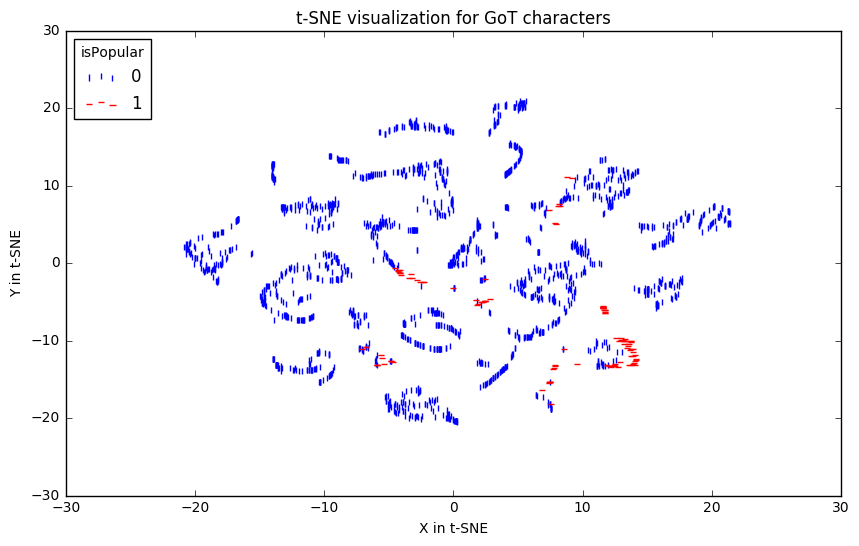

In [18]:
plotTSNE("isPopular", x_extended_std_2d, y_all_extended)

# From above, taking only commanders

In [19]:
y_all_extended.columns

Index(['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried',
       'boolDeadRelations', 'isPopular', 'isAlive', 'hadMoreWinsThanLosses',
       'wasAttackerCommander', 'wasDefenderCommander', 'wasCommander',
       'preferredBattleType'],
      dtype='object')

In [20]:
filterLabel = "wasCommander"
filterValue = 1
x_filtered_std_2d = np.array(list(it.compress(x_extended_std_2d, y_all_extended[filterLabel] == filterValue)))
y_filtered = y_all_extended.loc[y_all_extended[filterLabel].values == filterValue]

Counter({0: 49, 1: 28})
Counter({0: 0.6363636363636364, 1: 0.36363636363636365})


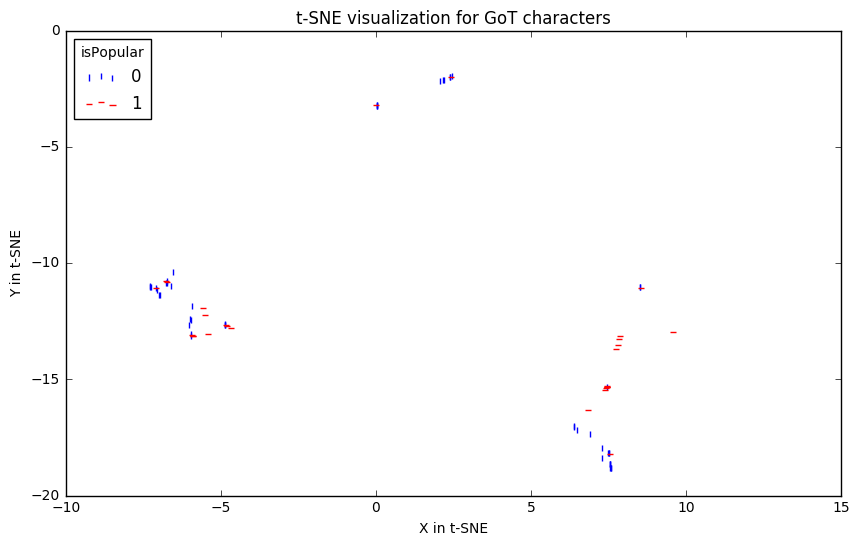

In [21]:
plotTSNE("isPopular", x_filtered_std_2d, y_filtered)

# Fitting data only for commanders

In [22]:
x_commanders = x_extended.loc[y_all_extended['wasCommander'].values == 1]
y_commanders = y_all_extended.loc[y_all_extended['wasCommander'].values == 1]
x_commanders.head()

,alive,numDeadRelations,popularity,bookCount,witnessed_wins,witnessed_losses,witnessed_own_attacker_size_mean,witnessed_opponent_attacker_size_mean,witnessed_own_defender_size_mean,witnessed_opponent_defender_size_mean,witnessed_major_deaths,witnessed_major_capture,battleCountAsAttackerCommander,battleCountAsDefenderCommander,battleCountAsCommander
name,,,,,,,,,,,,,,,
Walder Frey,0.387,1.0,0.896321,5.0,3.0,0.0,3166.666667,0.0,0.0,1166.666667,1.0,2.0,3.0,0.0,3.0
Leobald Tallhart,0.875,0.0,0.110368,4.0,0.0,1.0,0.000000,618.0,2000.0,0.000000,1.0,0.0,0.0,1.0,1.0
Redwyn,0.712,0.0,0.006689,1.0,1.0,0.0,2000.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,1.0
Rob,0.705,0.0,0.003344,0.0,5.0,2.0,3829.166667,3500.0,3500.0,4787.500000,5.0,3.0,6.0,1.0,7.0
Robb Stark,0.036,7.0,1.000000,0.0,4.0,1.0,4968.750000,3500.0,3500.0,7156.250000,3.0,3.0,4.0,1.0,5.0


In [23]:
x_commanders_std_2d = mapToTSNE(x_commanders)

In [24]:
y_commanders.columns

Index(['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried',
       'boolDeadRelations', 'isPopular', 'isAlive', 'hadMoreWinsThanLosses',
       'wasAttackerCommander', 'wasDefenderCommander', 'wasCommander',
       'preferredBattleType'],
      dtype='object')

Counter({'pitched battle': 34, 'ambush': 25, 'siege': 17, 'razing': 1})
Counter({'pitched battle': 0.44155844155844154, 'ambush': 0.3246753246753247, 'siege': 0.22077922077922077, 'razing': 0.012987012987012988})


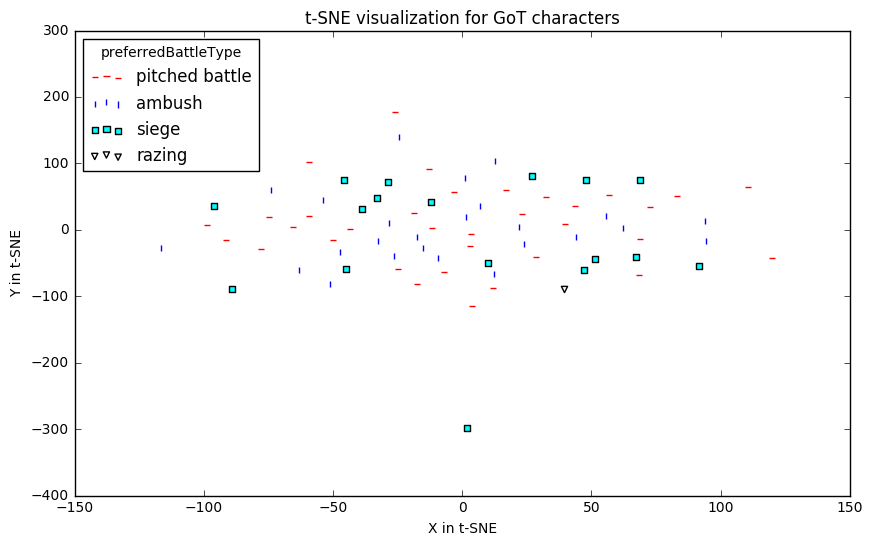

In [25]:
plotTSNE("preferredBattleType", x_commanders_std_2d, y_commanders)